In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import random
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader
import time
from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm

In [50]:
N_ITER = 20
POPULATION_SIZE = 50
MUT_PROB = 0.9
RECOMB_PROB = 0.1

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [52]:
image_resize = 64
transform = transforms.Compose([
    transforms.Resize((image_resize, image_resize)), # Resize to 128 x 128 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [53]:
# loading the train data
batch_size = 1024

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False )

Files already downloaded and verified
Files already downloaded and verified


### Dense (fully connected) layer

In [54]:
class Dense:
  def __init__(self, n_inputs, n_neurons):
    # He Weight Initialization
    self.weights = torch.randn(n_inputs, n_neurons) * torch.sqrt(torch.tensor(2. / n_inputs))
    self.biases = torch.zeros((1, n_neurons))
    self.weights = self.weights.to(device)
    self.biases = self.biases.to(device)
    self.prev_wchange = torch.zeros((n_inputs, n_neurons))
    self.prev_bchange = torch.zeros((1, n_neurons))
    self.prev_wchange = self.prev_wchange.to(device)
    self.prev_bchange = self.prev_bchange.to(device)

  
  def forward(self, inputs):
    self.inputs = inputs
    self.inputs = self.inputs.to(device)
    return torch.matmul(self.inputs, self.weights) + self.biases

  def backward(self, output_error):
    # calculating errors
    self.inputs_error = torch.matmul(output_error, self.weights.T)
    self.inputs_error = self.inputs_error.to(device)
    self.weights_grad = torch.matmul(self.inputs.T, output_error)
    self.weights_grad = self.weights_grad.to(device)
    self.biases_grad = torch.sum(output_error, axis=0, keepdims=True)
    self.biases_grad =  self.biases_grad.to(device)
    return self.inputs_error


### Activation Layers


In [55]:
class ReLU:
  def forward(self, inputs):
    self.inputs = inputs.clone()
    self.inputs = self.inputs.to(device)
    return torch.maximum(torch.zeros_like(inputs), inputs)

  def backward(self, output_error):
    self.inputs_error = output_error.clone()
    self.inputs_error = self.inputs_error.to(device)
    self.inputs_error[self.inputs <= 0] = 0
    return self.inputs_error

In [56]:
class Softmax:
  def forward(self, inputs):
    self.inputs = inputs.clone()
    self.inputs = self.inputs.to(device)
    exp_inputs = torch.exp(self.inputs - torch.max(self.inputs, dim=1, keepdim=True).values)
    exp_inputs = exp_inputs.to(device)
    self.outputs = exp_inputs / torch.sum(exp_inputs, dim=1, keepdim=True)
    self.outputs = self.outputs.to(device)
    return self.outputs

In [57]:
feature_extractor = resnet34(weights="DEFAULT")
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
  param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

In [58]:
def calculate_k(population_size, curr_iter):
  return max(2, population_size * curr_iter // N_ITER)

In [59]:
class Model:
  def __init__(self):
    self.Layer1 = Dense(num_features, 20)
    self.Act1 = ReLU()
    self.Layer2 = Dense(20, 10)
    self.Act2 = Softmax()
    self.y_predtr = torch.zeros(0, dtype=torch.long, device = device)
    self.y_true_train = torch.zeros(0, dtype=torch.long, device = device)
    self.y_predts = torch.zeros(0, dtype=torch.long, device = device)
    self.y_true_test = torch.zeros(0, dtype=torch.long, device = device)
        
  def get_train_accuracy(self, iter):
    train_accuracy = 0
    for x_train, y_train in tqdm(train_dataloader, desc=f"Training", colour="blue"):
      # Forward pass
      x_train, y_train = x_train.to(device), y_train.to(device)
      x = feature_extractor(x_train)
      x = self.Layer1.forward(x)
      x = self.Act1.forward(x)
      x = self.Layer2.forward(x)
      x = self.Act2.forward(x)
        
      y_predict_train = torch.argmax(x, dim=1)
      accuracy = torch.mean((y_train == y_predict_train).float())
      train_accuracy += accuracy.item()
      if iter == N_ITER:
        self.y_predtr = torch.cat([self.y_predtr, y_predict_train.view(-1)])
        self.y_true_train = torch.cat([self.y_true_train, y_train.view(-1)])
        
    train_accuracy /= len(train_dataloader)
    return train_accuracy

  def get_test_accuracy(self, iter):
    test_accuracy = 0
    with torch.no_grad():
      for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
        # Forward pass
        x_test, y_test = x_test.to(device), y_test.to(device)
        x = feature_extractor(x_test)
        x = self.Layer1.forward(x)
        x = self.Act1.forward(x)
        x = self.Layer2.forward(x)
        x = self.Act2.forward(x)

        # Report batch metrics
        y_predict_test = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_test == y_predict_test).float())
        test_accuracy += accuracy.item()
        if iter == N_ITER:
          self.y_predts = torch.cat([self.y_predts,y_predict_test.view(-1)])
          self.y_true_test=torch.cat([self.y_true_test, y_test.view(-1)])

    test_accuracy /= len(test_dataloader)
    return test_accuracy

In [60]:
class Chromosome:
  def __init__(self, mut_prob, recomb_prob, id, calc_fitness):
    self.model = None
    self.id = id
    self.current_iter = 0
    self.mut_prob = mut_prob
    self.recomb_prob = recomb_prob
    self.train_fitness = 0
    self.test_fitness = 0
    self.calc_fitness = calc_fitness
    self.init_chromosome()
      
  def init_chromosome(self):
    self.model = Model()
    if self.calc_fitness:
      self.calculate_fitness()
      
  def mutation(self):
    for i in range(len(self.model.Layer1.weights)):
      prob = random.uniform(0, 1)
      if prob <= self.mut_prob:
        for j in range(len(self.model.Layer1.weights[i])):
          r = random.gauss(0, 0.5)
          new_w = self.model.Layer1.weights[i, j] + r
          self.model.Layer1.weights[i, j] = max(min(1.5, new_w), -1.5)
            
    for i in range(len(self.model.Layer2.weights)):
      prob = random.uniform(0, 1)
      if prob <= self.mut_prob:
        for j in range(len(self.model.Layer2.weights[i])):
          r = random.gauss(0, 0.5)
          new_w = self.model.Layer2.weights[i, j] + r
          self.model.Layer2.weights[i, j] = max(min(1.5, new_w), -1.5)
        
    for i in range(len(self.model.Layer1.biases)):
      prob = random.uniform(0, 1)
      if prob <= self.mut_prob:
        for j in range(len(self.model.Layer1.biases[i])):
          r = random.gauss(0, 0.5)
          new_b = self.model.Layer1.biases[i, j] + r
          self.model.Layer1.biases[i, j] = max(min(1.5, new_b), -1.5)
            
    for i in range(len(self.model.Layer2.biases)):
      prob = random.uniform(0, 1)
      if prob <= self.mut_prob:
        for j in range(len(self.model.Layer2.biases[i])):
          r = random.gauss(0, 0.5)
          new_b = self.model.Layer2.biases[i, j] + r
          self.model.Layer2.biases[i, j] = max(min(1.5, new_b), -1.5)
        
    self.calculate_fitness()

  def calculate_fitness(self):
    print(f"Chromosome: {self.id}")
    self.train_fitness = self.model.get_train_accuracy(self.current_iter)
    self.test_fitness = self.model.get_test_accuracy(self.current_iter)

In [61]:
class EvolutionaryAlgorithm:
  def __init__(self, n_iter, mut_prob, recomb_prob, population_size):
    self.n_iter = n_iter
    self.mut_prob = mut_prob
    self.recomb_prob = recomb_prob
    self.population = []
    self.population_size = population_size
    self.current_iter = 0
    self.train_fitness_avg = 0
    self.test_fitness_avg = 0
    self.train_acc = {'128':[]}
    self.test_acc = {'128':[]}

  # Random initialization
  def init_population(self):
    for id in range(self.population_size):
      young_pop = Chromosome(self.mut_prob, self.recomb_prob, id + 1, True)
      self.population.append(young_pop)

  # Fitness Tournament selection
  def tournament_selection(self, tour_pop, k):
    parents = random.sample(tour_pop, k=k)
    parents = sorted(parents, key=lambda agent: agent.train_fitness, reverse=True)
    bestparent = parents[0]
    
    return bestparent

  def parent_selection(self):
    parents = []
    for _ in range(self.population_size):
      best_parent = self.tournament_selection(self.population, calculate_k(len(self.population), self.current_iter))
      parents.append(best_parent)

    return parents
  
  def crossover(self, nn1_weights, nn2_weights):
    child_weights = torch.empty((nn1_weights.shape[0], nn1_weights.shape[1]))
    for i in range(len(nn1_weights)):
      split = random.randint(0, nn1_weights[i].shape[0]-1)
      child_weights[i] = torch.cat((nn1_weights[i][:split], nn2_weights[i][split:]), 0)
        
    return child_weights

#     # One-point crossover
#     def recombination(self, mating_pool):
#         youngs = []
#         for _ in range(self.population_size // 2):
#             parents = random.choices(mating_pool, k=2)
#             young_1 = Chromosome(self.mut_prob, self.recomb_prob)
#             young_2 = Chromosome(self.mut_prob, self.recomb_prob)
#             prob = random.uniform(0, 1)
#             if prob <= self.recomb_prob:
#                 young_1.model.Layer1.weights = self.crossover(parents[0].model.Layer1.weights.detach().clone(), parents[1].model.Layer1.weights.detach().clone())
#                 young_2.model.Layer1.weights = self.crossover(parents[1].model.Layer1.weights.detach().clone(), parents[0].model.Layer1.weights.detach().clone())
#                 young_1.model.Layer2.weights = self.crossover(parents[0].model.Layer2.weights.detach().clone(), parents[1].model.Layer2.weights.detach().clone())
#                 young_2.model.Layer2.weights = self.crossover(parents[1].model.Layer2.weights.detach().clone(), parents[0].model.Layer2.weights.detach().clone())
#             else:
#                 young_1.model.Layer1.weights = parents[0].model.Layer1.weights.detach().clone()
#                 young_2.model.Layer1.weights = parents[1].model.Layer1.weights.detach().clone()
#                 young_1.model.Layer2.weights = parents[0].model.Layer2.weights.detach().clone()
#                 young_2.model.Layer2.weights = parents[1].model.Layer2.weights.detach().clone()

#             youngs.append(young_1)
#             youngs.append(young_2)
          
#         return youngs
  
  # Whole crossover
  def recombination(self, mating_pool):
    youngs = []
    for _ in range(self.population_size):
      parents = random.choices(mating_pool, k=2)
      young = Chromosome(self.mut_prob, self.recomb_prob, 0, False)
      prob = random.uniform(0, 1)
      alpha = random.uniform(0, 1)
      young.model.Layer1.weights = ((alpha * parents[0].model.Layer1.weights.detach().clone()) 
                                  + ((1 - alpha) * parents[1].model.Layer1.weights.detach().clone()))

      young.model.Layer2.weights = ((alpha * parents[0].model.Layer2.weights.detach().clone()) 
                                  + ((1 - alpha) * parents[1].model.Layer2.weights.detach().clone()))

      young.model.Layer1.biases = ((alpha * parents[0].model.Layer1.biases.detach().clone()) 
                                  + ((1 - alpha) * parents[1].model.Layer1.biases.detach().clone()))

      young.model.Layer2.biases = ((alpha * parents[0].model.Layer2.biases.detach().clone()) 
                                  + ((1 - alpha) * parents[1].model.Layer2.biases.detach().clone()))

      youngs.append(young)
        
    return youngs


  def survival_selection(self, youngs):
    mpl = self.population.copy() + youngs
    mpl = sorted(mpl, key=lambda agent: agent.train_fitness, reverse=True)
    mpl = mpl[:self.population_size].copy()
    
    return mpl

  def mutation(self, youngs):
    for young in youngs:
      young.current_iter = self.current_iter + 1
      young.mutation()
        
    return youngs
      
  def calculate_train_fitness_avg(self):
    self.train_fitness_avg = 0
    for pop in self.population:
      self.train_fitness_avg += pop.train_fitness
        
    self.train_fitness_avg /= self.population_size

  def calculate_test_fitness_avg(self):
    self.test_fitness_avg = 0
    for pop in self.population:
      self.test_fitness_avg += pop.test_fitness
        
    self.test_fitness_avg /= self.population_size

  def set_id(self, youngs):
    for id, young in enumerate(youngs):
      young.id  = id + 1

    return youngs

  def run(self):
    print("------------------------------------Initialization------------------------------------")
    self.init_population()
    print("------------------------------------Training------------------------------------")
    for _ in range(self.n_iter):
      parents = self.parent_selection().copy()
      youngs = self.recombination(parents).copy()
      youngs = self.set_id(youngs).copy()
      youngs = self.mutation(youngs).copy()
      self.population = self.survival_selection(youngs).copy()
      self.calculate_train_fitness_avg()
      self.calculate_test_fitness_avg()
      self.current_iter += 1
      best_current = sorted(self.population, key=lambda agent: agent.train_fitness, reverse=True)[0]
      print(f"current iteration: {self.current_iter} / {self.n_iter}",
            f", best train fitness: {best_current.train_fitness}, average train fitness: {self.train_fitness_avg}, average test fitness: {self.test_fitness_avg}")
      print("-------------------------------------------------------------------------------------------------")
      self.train_acc['128'].append(self.train_fitness_avg)
      self.test_acc['128'].append(self.test_fitness_avg)

    ans = sorted(self.population, key=lambda agent: agent.train_fitness, reverse=True)[0]
    
    return ans, self.train_acc, self.test_acc

In [62]:
ea = EvolutionaryAlgorithm(N_ITER, MUT_PROB, RECOMB_PROB, POPULATION_SIZE)
ans, train_acc, test_acc = ea.run()

------------------------------------Initialization------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


------------------------------------Training------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


current iteration: 1 / 20 , best train fitness: 0.12920858209230462, average train fitness: 0.11005474319567485, average test fitness: 0.11014333522319796
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


current iteration: 2 / 20 , best train fitness: 0.12920858209230462, average train fitness: 0.11454232803716952, average test fitness: 0.11531544932723044
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


current iteration: 3 / 20 , best train fitness: 0.12941540123856798, average train fitness: 0.11774363302758765, average test fitness: 0.11787862692773342
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


current iteration: 4 / 20 , best train fitness: 0.15000669354078722, average train fitness: 0.12212632670694468, average test fitness: 0.12135279786586758
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


current iteration: 5 / 20 , best train fitness: 0.15000669354078722, average train fitness: 0.12565873790152218, average test fitness: 0.12487978291511544
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


current iteration: 6 / 20 , best train fitness: 0.15000669354078722, average train fitness: 0.12965970355029013, average test fitness: 0.1275271840691567
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


current iteration: 7 / 20 , best train fitness: 0.15000669354078722, average train fitness: 0.1338622539657719, average test fitness: 0.13187456126511096
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


current iteration: 8 / 20 , best train fitness: 0.1582192945845273, average train fitness: 0.1392571657531116, average test fitness: 0.13705656059086324
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


current iteration: 9 / 20 , best train fitness: 0.16951199696988475, average train fitness: 0.14488944578839802, average test fitness: 0.14249039353430276
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


current iteration: 10 / 20 , best train fitness: 0.16951199696988475, average train fitness: 0.15127975942224875, average test fitness: 0.14811168654263024
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


current iteration: 11 / 20 , best train fitness: 0.1788436779562308, average train fitness: 0.1552598701843194, average test fitness: 0.15165401758253572
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


current iteration: 12 / 20 , best train fitness: 0.1788436779562308, average train fitness: 0.1573281370559517, average test fitness: 0.15378443855047225
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


current iteration: 13 / 20 , best train fitness: 0.1788436779562308, average train fitness: 0.1593992241973779, average test fitness: 0.15528854408860204
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


current iteration: 14 / 20 , best train fitness: 0.1788436779562308, average train fitness: 0.16122615191401268, average test fitness: 0.15694961708784103
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


current iteration: 15 / 20 , best train fitness: 0.1788436779562308, average train fitness: 0.16188294941065262, average test fitness: 0.1578692201077938
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


current iteration: 16 / 20 , best train fitness: 0.1788436779562308, average train fitness: 0.16278885496514184, average test fitness: 0.15885044622421268
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


current iteration: 17 / 20 , best train fitness: 0.1788436779562308, average train fitness: 0.16468518367227244, average test fitness: 0.16058163240551948
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


current iteration: 18 / 20 , best train fitness: 0.18646477618995977, average train fitness: 0.16632912529366362, average test fitness: 0.1620728633105755
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


current iteration: 19 / 20 , best train fitness: 0.18646477618995977, average train fitness: 0.16705439122355717, average test fitness: 0.16276929181814195
-------------------------------------------------------------------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 5


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Chromosome: 6


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Chromosome: 7


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Chromosome: 8


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Chromosome: 9


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Chromosome: 10


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Chromosome: 11


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Chromosome: 12


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 13


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 14


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 15


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 16


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 17


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Chromosome: 18


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Chromosome: 19


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Chromosome: 20


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Chromosome: 21


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Chromosome: 22


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Chromosome: 23


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Chromosome: 24


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Chromosome: 25


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Chromosome: 26


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 27


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Chromosome: 28


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Chromosome: 29


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 30


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Chromosome: 31


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Chromosome: 32


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Chromosome: 33


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Chromosome: 34


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Chromosome: 35


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Chromosome: 36


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Chromosome: 37


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Chromosome: 38


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Chromosome: 39


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Chromosome: 40


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Chromosome: 41


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Chromosome: 42


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Chromosome: 43


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Chromosome: 44


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Chromosome: 45


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Chromosome: 46


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Chromosome: 47


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Chromosome: 48


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Chromosome: 49


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Chromosome: 50


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

current iteration: 20 / 20 , best train fitness: 0.18646477618995977, average train fitness: 0.16786418226908664, average test fitness: 0.16341075387597087
-------------------------------------------------------------------------------------------------


In [79]:
y_predtr= torch.zeros(0,dtype=torch.long, device=device)
y_true_train = torch.zeros(0,dtype=torch.long, device=device)
y_predts= torch.zeros(0,dtype=torch.long, device=device)
y_true_test = torch.zeros(0,dtype=torch.long, device=device)
test_accuracy =  0
for x_train, y_train in tqdm(train_dataloader, desc=f"confusion matrix train", colour="blue"):
        # Forward pass
        x_train, y_train = x_train.to(device), y_train.to(device)
        x = feature_extractor(x_train)
        x = ans.model.Layer1.forward(x)
        x = ans.model.Act1.forward(x)
        x = ans.model.Layer2.forward(x)
        x = ans.model.Act2.forward(x)
        

        # Report batch metrics
        y_predict_train = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_train == y_predict_train).float())
        y_predtr=torch.cat([y_predtr,y_predict_train.view(-1)])
        y_true_train=torch.cat([y_true_train,y_train.view(-1)])

with torch.no_grad():
    for x_test, y_test in tqdm(test_dataloader, desc=f"onfusion matrix test", colour="green"):
            # Forward pass
            x_test, y_test = x_test.to(device), y_test.to(device)
            x = feature_extractor(x_test)
            x = ans.model.Layer1.forward(x)
            x = ans.model.Act1.forward(x)
            x = ans.model.Layer2.forward(x)
            x = ans.model.Act2.forward(x)
            

            # Report batch metrics
            y_predict_test = torch.argmax(x, dim=1)
            accuracy = torch.mean((y_test == y_predict_test).float())
            test_accuracy += accuracy.item()
            y_predts=torch.cat([y_predts,y_predict_test.view(-1)])
            y_true_test=torch.cat([y_true_test,y_test.view(-1)])

test_accuracy /= len(test_dataloader)
print(test_accuracy)

onfusion matrix test: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

0.1797931283712387


In [80]:
print(test_accuracy)

0.1797931283712387


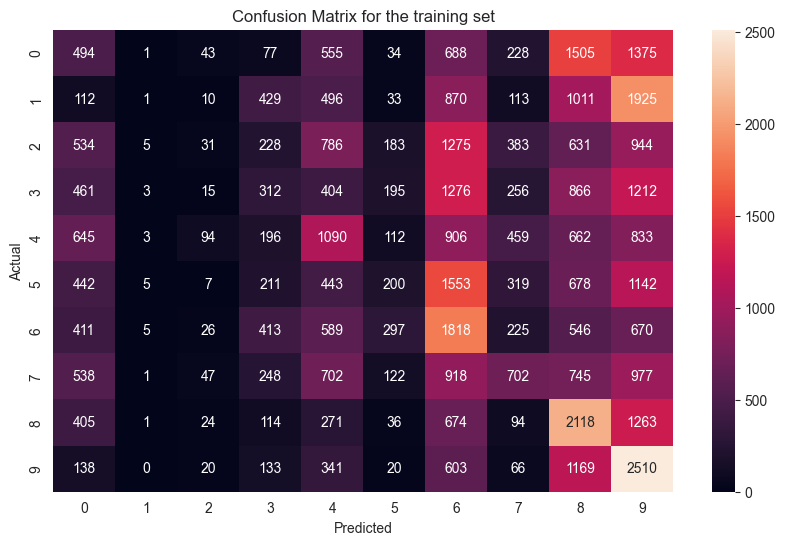

In [70]:
#Confusion Matrix for the training set
y_predtr_numpy = y_predtr.data.cpu().numpy()
y_train_numpy = y_true_train.data.cpu().numpy()
cm_train = confusion_matrix(y_train_numpy, y_predtr_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()

In [71]:
print(f1_score(y_train_numpy, y_predtr_numpy, average='weighted'))

0.1450067561763057


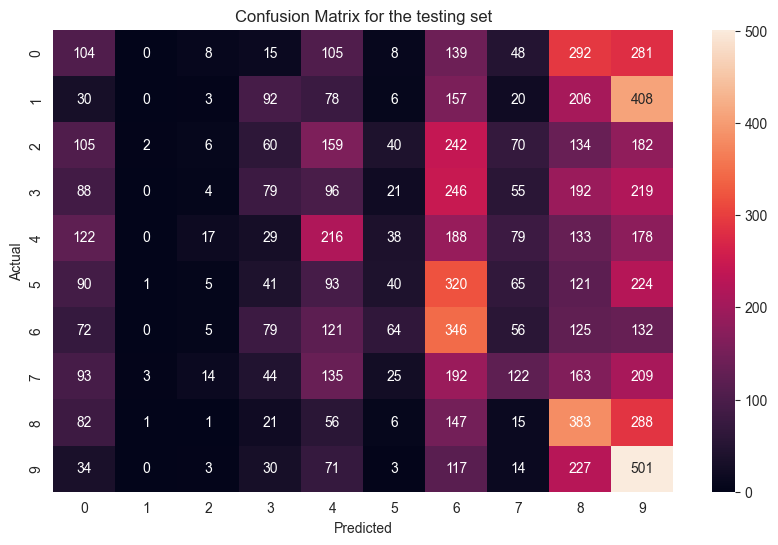

In [73]:
#Confusion Matrix for the test set
y_predts_numpy = y_predts.data.cpu().numpy()
y_test_numpy = y_true_test.data.cpu().numpy()
cm_train = confusion_matrix(y_test_numpy, y_predts_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the testing set")
plt.show()

In [74]:
print(f1_score(y_test_numpy, y_predts_numpy, average='weighted'))

0.1414073754991522


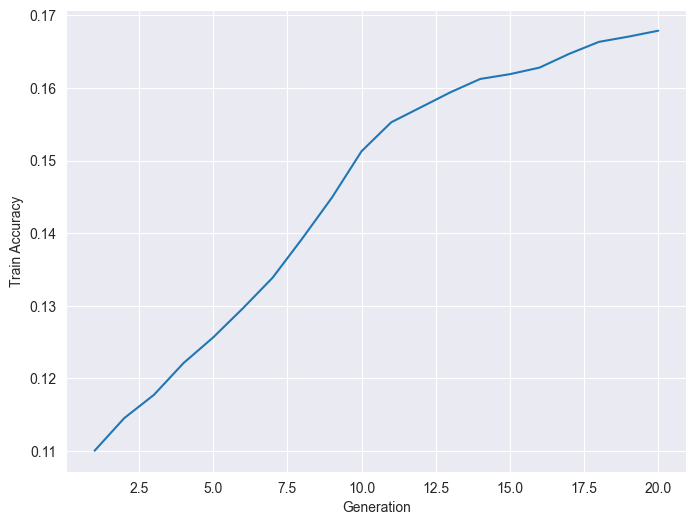

In [76]:
# train acc 
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in train_acc.items():
    sb.lineplot(x=range(1, N_ITER + 1), y=data)

# Add labels and legend
plt.ylabel('Train Accuracy')
plt.xlabel('Generation')


# Show the plot
plt.show()

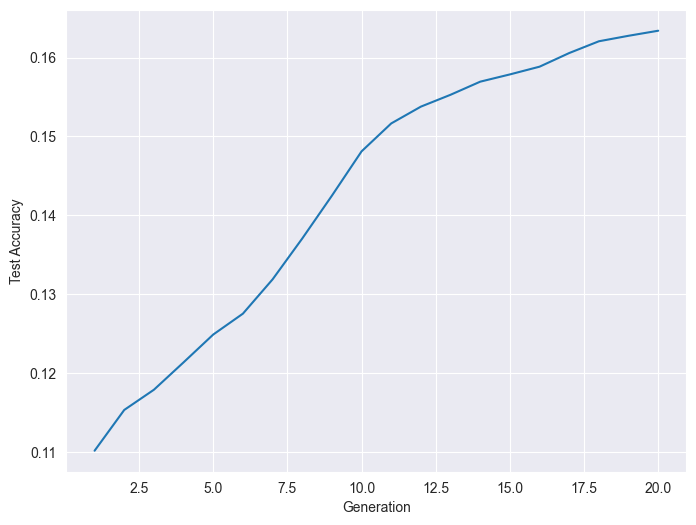

In [77]:
# test acc 
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in test_acc.items():
    sb.lineplot(x=range(1, N_ITER + 1), y=data)

# Add labels and legend
plt.ylabel('Test Accuracy')
plt.xlabel('Generation')


# Show the plot
plt.show()